In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import os
import re
import string
import sys
import nltk
from nltk import pos_tag_sents
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
import spacy


# Input data files are available in the read-only "../input/" directory
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


# Initializing
---

In [2]:
train = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
test = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")
sample = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")
train.head(10)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [4]:
info = pd.DataFrame(index = train.columns,columns = ['unique','null','% null'])
unique = train.apply(pd.Series.nunique)
nulls = train.isnull().sum()
info['unique'] = unique
info['null']= nulls
info['% null'] = round((nulls/len(train))*100,2)
info

,unique,null,% null
id,7613,0,0.00
keyword,221,61,0.80
location,3341,2533,33.27
text,7503,0,0.00
target,2,0,0.00


In [5]:
df = train.copy(deep= True)
df['keyword'].fillna('no_keyword', inplace=True)
df['location'].fillna('no_location', inplace=True)

## Fake Tweets vs Real tweets 

<AxesSubplot:xlabel='target', ylabel='count'>

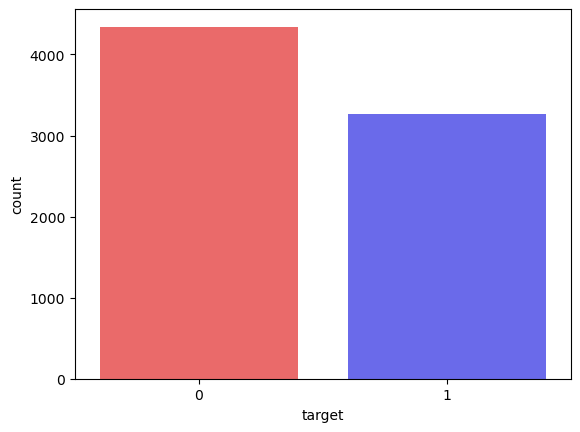

In [6]:
sns.countplot(x = 'target', data = df, palette = 'seismic_r')

<AxesSubplot:xlabel='text', ylabel='keyword'>

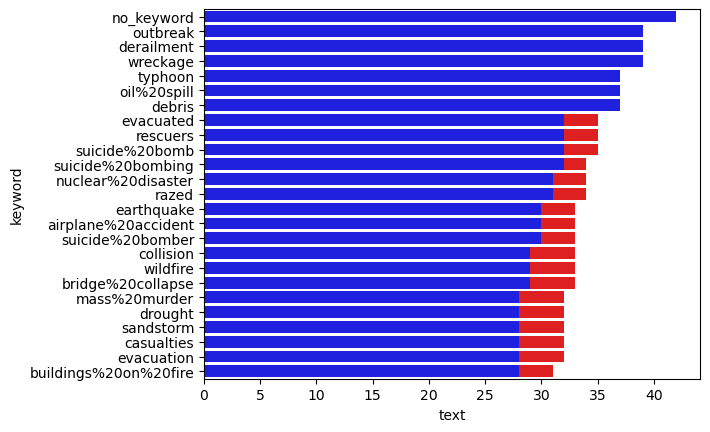

In [7]:
keyword_fake = df[df['target'] == 0].groupby('keyword').count().drop(columns=['target', 'id']).sort_values(by='text', ascending=False)[:25]
keyword_real = df[df['target'] == 1].groupby('keyword').count().drop(columns=['target', 'id']).sort_values(by='text', ascending=False)[:25]

sns.barplot(data=keyword_fake,y=keyword_real.index, x = 'text',color='red',) #number of fake tweets
sns.barplot(data=keyword_real,y=keyword_real.index, x = 'text',color='blue')#number of real tweets

# **Cleaning**
---

In [8]:
df['text'] = df['text'].astype("string")
df.drop_duplicates(subset = 'text',inplace = True)
df.sample(10)

,id,keyword,location,text,target
3422,4895,explode,no_location,@allen_enbot If you mess up it's gonna explode...,1
5043,7191,mudslide,no_location,When bae soak you in mudslide at backroom???? ...,0
2047,2937,danger,no_location,The Danger and Excitement of Underwater Cave D...,0
7270,10409,whirlwind,Stamford & Cork (& Shropshire),I moved to England five years ago today. What ...,1
989,1436,body%20bagging,no_location,@MeekMill is w(rec)k league ball @Drake is Oly...,0
7435,10636,wounds,Charlotte,Gunshot wound #9 is in the bicep. The only one...,1
395,570,arson,"Eldoret, kenya",#Kisii Police in Kisii hunt for students over ...,1
1705,2460,collided,"-6.152261,106.775995",When love and hate collided part II Lanjut dir...,0
758,1094,blew%20up,?205?478?,Max blew tf up ! ?????? shots fired ???? #Catf...,0
2530,3634,desolation,"Manila, Philippines",Beautiful desolation. Just me a couple of coyo...,0


## Removing punctiation
* remove rewtweets/hastags/urls/

In [9]:
#Creating new dataframe
tweets = pd.DataFrame(df.text)
tweets['clean'] = df.text
#Removing RT, Punctuation etc
remove_rt = lambda x: re.sub('RT @\w+: '," ",x)
remove_usernames = lambda x: re.sub('@[^\s]+',' ',x)
remove_urls = lambda x: re.sub(r'http\S+', '', x)
remove_punctuation = lambda x: re.sub('[^a-zA-Z\s]+', ' ', x)
remove_hashtags = lambda x: re.sub('\B#\w*[a-zA-Z]+\w*', ' ', x)
lowercase = lambda x: x.lower()

tweets['clean'] = tweets.text.map(remove_rt).map(remove_usernames).map(remove_urls).map(remove_punctuation).map(remove_hashtags).map(lowercase)
tweets.sample(10, random_state = 42)
#tweets.loc[978]

,text,clean
2330,Three Homes Demolished in Unrecognized Arab Vi...,three homes demolished in unrecognized arab vi...
3391,Reid Lake fire prompts campground evacuation o...,reid lake fire prompts campground evacuation o...
3363,FAAN orders evacuation of abandoned aircraft a...,faan orders evacuation of abandoned aircraft a...
4632,Ngata on injury list at start of practice for ...,ngata on injury list at start of practice for ...
7588,BREAKING: #ISIS claims responsibility for mosq...,breaking isis claims responsibility for mosq...
4862,Reminder: Mass murderer and white supremacist ...,reminder mass murderer and white supremacist ...
1561,@D33munni @JeanNamibian noooooooo ... *proceed...,noooooooo proceeds to fall off a cliff
4061,' no pharrell only YOU can prevent forest fir...,no pharrell only you can prevent forest fir...
1721,SSP East says a car AEG 061 driven by a young ...,ssp east says a car aeg driven by a young ma...
3138,Deals : http://t.co/ddhWoRI5w1 #37592 Temporar...,deals temporary fake tooth teeth replacem...


## NLTK Cleaning
* Tokenization
* Stop word removal
* tagging


In [10]:
tweets['tokenized'] = tweets.clean.apply(lambda x: word_tokenize(x.lower()))
stopword = nltk.corpus.stopwords.words('english')
def remove_stop(text):
    text = [word for word in text if word not in stopword]
    return text
tweets['sw_removed']= tweets.tokenized.apply(lambda x: remove_stop(x))
tweets.sample(10, random_state =42)

,text,clean,tokenized,sw_removed
2330,Three Homes Demolished in Unrecognized Arab Vi...,three homes demolished in unrecognized arab vi...,"[three, homes, demolished, in, unrecognized, a...","[three, homes, demolished, unrecognized, arab,..."
3391,Reid Lake fire prompts campground evacuation o...,reid lake fire prompts campground evacuation o...,"[reid, lake, fire, prompts, campground, evacua...","[reid, lake, fire, prompts, campground, evacua..."
3363,FAAN orders evacuation of abandoned aircraft a...,faan orders evacuation of abandoned aircraft a...,"[faan, orders, evacuation, of, abandoned, airc...","[faan, orders, evacuation, abandoned, aircraft..."
4632,Ngata on injury list at start of practice for ...,ngata on injury list at start of practice for ...,"[ngata, on, injury, list, at, start, of, pract...","[ngata, injury, list, start, practice, lions]"
7588,BREAKING: #ISIS claims responsibility for mosq...,breaking isis claims responsibility for mosq...,"[breaking, isis, claims, responsibility, for, ...","[breaking, isis, claims, responsibility, mosqu..."
4862,Reminder: Mass murderer and white supremacist ...,reminder mass murderer and white supremacist ...,"[reminder, mass, murderer, and, white, suprema...","[reminder, mass, murderer, white, supremacist,..."
1561,@D33munni @JeanNamibian noooooooo ... *proceed...,noooooooo proceeds to fall off a cliff,"[noooooooo, proceeds, to, fall, off, a, cliff]","[noooooooo, proceeds, fall, cliff]"
4061,' no pharrell only YOU can prevent forest fir...,no pharrell only you can prevent forest fir...,"[no, pharrell, only, you, can, prevent, forest...","[pharrell, prevent, forest, fires]"
1721,SSP East says a car AEG 061 driven by a young ...,ssp east says a car aeg driven by a young ma...,"[ssp, east, says, a, car, aeg, driven, by, a, ...","[ssp, east, says, car, aeg, driven, young, man..."
3138,Deals : http://t.co/ddhWoRI5w1 #37592 Temporar...,deals temporary fake tooth teeth replacem...,"[deals, temporary, fake, tooth, teeth, replace...","[deals, temporary, fake, tooth, teeth, replace..."


In [11]:
#nltk.download('averaged_perceptron_tagger')

def tag_words(words):
    return pos_tag_sents([words])[0]

tweets['tagged'] = tweets['sw_removed'].apply(tag_words)

tweets.sample(10, random_state =42)

,text,clean,tokenized,sw_removed,tagged
2330,Three Homes Demolished in Unrecognized Arab Vi...,three homes demolished in unrecognized arab vi...,"[three, homes, demolished, in, unrecognized, a...","[three, homes, demolished, unrecognized, arab,...","[(three, CD), (homes, NNS), (demolished, VBD),..."
3391,Reid Lake fire prompts campground evacuation o...,reid lake fire prompts campground evacuation o...,"[reid, lake, fire, prompts, campground, evacua...","[reid, lake, fire, prompts, campground, evacua...","[(reid, NNS), (lake, VBP), (fire, NN), (prompt..."
3363,FAAN orders evacuation of abandoned aircraft a...,faan orders evacuation of abandoned aircraft a...,"[faan, orders, evacuation, of, abandoned, airc...","[faan, orders, evacuation, abandoned, aircraft...","[(faan, JJ), (orders, NNS), (evacuation, NN), ..."
4632,Ngata on injury list at start of practice for ...,ngata on injury list at start of practice for ...,"[ngata, on, injury, list, at, start, of, pract...","[ngata, injury, list, start, practice, lions]","[(ngata, JJ), (injury, NN), (list, NN), (start..."
7588,BREAKING: #ISIS claims responsibility for mosq...,breaking isis claims responsibility for mosq...,"[breaking, isis, claims, responsibility, for, ...","[breaking, isis, claims, responsibility, mosqu...","[(breaking, VBG), (isis, NN), (claims, NNS), (..."
4862,Reminder: Mass murderer and white supremacist ...,reminder mass murderer and white supremacist ...,"[reminder, mass, murderer, and, white, suprema...","[reminder, mass, murderer, white, supremacist,...","[(reminder, NN), (mass, NN), (murderer, NN), (..."
1561,@D33munni @JeanNamibian noooooooo ... *proceed...,noooooooo proceeds to fall off a cliff,"[noooooooo, proceeds, to, fall, off, a, cliff]","[noooooooo, proceeds, fall, cliff]","[(noooooooo, JJ), (proceeds, NNS), (fall, VBP)..."
4061,' no pharrell only YOU can prevent forest fir...,no pharrell only you can prevent forest fir...,"[no, pharrell, only, you, can, prevent, forest...","[pharrell, prevent, forest, fires]","[(pharrell, NN), (prevent, NN), (forest, NN), ..."
1721,SSP East says a car AEG 061 driven by a young ...,ssp east says a car aeg driven by a young ma...,"[ssp, east, says, a, car, aeg, driven, by, a, ...","[ssp, east, says, car, aeg, driven, young, man...","[(ssp, NN), (east, NN), (says, VBZ), (car, NN)..."
3138,Deals : http://t.co/ddhWoRI5w1 #37592 Temporar...,deals temporary fake tooth teeth replacem...,"[deals, temporary, fake, tooth, teeth, replace...","[deals, temporary, fake, tooth, teeth, replace...","[(deals, NNS), (temporary, JJ), (fake, VBP), (..."


In [12]:
#nltk tags
nltk.help.upenn_tagset()

$: dollar
    $ -$ --$ A$ C$ HK$ M$ NZ$ S$ U.S.$ US$
'': closing quotation mark
    ' ''
(: opening parenthesis
    ( [ {
): closing parenthesis
    ) ] }
,: comma
    ,
--: dash
    --
.: sentence terminator
    . ! ?
:: colon or ellipsis
    : ; ...
CC: conjunction, coordinating
    & 'n and both but either et for less minus neither nor or plus so
    therefore times v. versus vs. whether yet
CD: numeral, cardinal
    mid-1890 nine-thirty forty-two one-tenth ten million 0.5 one forty-
    seven 1987 twenty '79 zero two 78-degrees eighty-four IX '60s .025
    fifteen 271,124 dozen quintillion DM2,000 ...
DT: determiner
    all an another any both del each either every half la many much nary
    neither no some such that the them these this those
EX: existential there
    there
FW: foreign word
    gemeinschaft hund ich jeux habeas Haementeria Herr K'ang-si vous
    lutihaw alai je jour objets salutaris fille quibusdam pas trop Monte
    terram fiche oui corporis ...
IN: preposition or

# Feature Extraction
---

# Citation
---
Bird, Steven, Edward Loper and Ewan Klein (2009), Natural Language Processing with Python. O’Reilly Media Inc.